In [269]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:
import pandas as pd
import hw4_cluster as hwc
import pipeline as pl
import edited_pipeline as ep
#i want to see all columns in my dataframes
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Reading the data

In [199]:
data = hwc.read_data('/Users/csolisu/Downloads/projects_2012_2013.csv')

In [200]:
data.isnull().sum()

projectid                                     0
teacher_acctid                                0
schoolid                                      0
school_ncesid                              9233
school_latitude                               0
school_longitude                              0
school_city                                   0
school_state                                  0
school_metro                              15224
school_district                             172
school_county                                 0
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                             

First of all, we generate the label of interest

In [201]:
data['days_financed'] = pd.to_datetime(data['datefullyfunded']) - pd.to_datetime(data['date_posted'])
data['label'] = data['days_financed'].dt.days.apply(lambda x: 0 if x <= 60 else 1)

...then, we preprocess the data

In [202]:
#dropping variables we won't use
drop_lst = ['projectid', 'teacher_acctid', 'schoolid',
            'school_ncesid', 'school_latitude', 
            'school_longitude', 'school_district','school_county','secondary_focus_subject',
            'secondary_focus_area','primary_focus_subject']
unnecesary_lst = ['datefullyfunded', 'days_financed', 'school_city', 'school_state']

hwc.drop_features(data, drop_lst)
hwc.drop_features(data, unnecesary_lst)

#filling the missing data
lst_to_fill = ['primary_focus_area',
               'resource_type', 'grade_level', 'students_reached']

hwc.fill_missing(data,lst_to_fill,form = False)

#turning variables into dummies
lst_dummies = ['school_metro', 
               'primary_focus_area', 'resource_type', 'poverty_level',
              'grade_level']
data = hwc.to_dummies(data,lst_dummies)
hwc.drop_features(data, lst_dummies)

#cleaning the gender of teacher, which might be important
d_t = pd.get_dummies(data['teacher_prefix'])
d_t_lst = list(d_t.columns)
d_t['female_teacher'] = d_t['Dr.'] + d_t['Ms.'] + d_t['Mrs.'] 
d_t['male_teacher'] = d_t['Mr.']
hwc.drop_features(d_t, d_t_lst)
data.join(d_t)

final_drop = ['teacher_prefix']
hwc.drop_features(data, final_drop)
#turning 
tf_dic = {'t': 1, 'f':0}
data = data.replace({'school_charter': tf_dic, 'school_magnet': tf_dic, 'eligible_double_your_impact_match' : tf_dic})


In [310]:
data_cluster = data.copy()
data_cluster.drop(columns='date_posted', inplace = True, axis = 1)
data_cluster.drop(columns='label', inplace = True, axis = 1)

In [249]:
data_cluster.describe()

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,school_metro_rural,school_metro_suburban,school_metro_urban,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2
count,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000
mean,0.093106,0.085640,654.011811,95.414864,0.296769,0.115230,0.264723,0.498232,0.069789,0.027965,0.041272,0.448614,0.253681,0.091882,0.066797,0.193845,0.109877,0.322222,0.367295,0.005617,0.001144,0.274941,0.542120,0.030382,0.152557,0.313996,0.171865,0.132201,0.381937
std,0.290582,0.279833,1098.015854,163.449500,0.456836,0.319301,0.441187,0.499999,0.254793,0.164874,0.198919,0.497354,0.435119,0.288860,0.249671,0.395311,0.312738,0.467329,0.482070,0.074737,0.033807,0.446486,0.498225,0.171636,0.359562,0.464117,0.377265,0.338711,0.485863
min,0.000000,0.000000,92.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,345.810000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,510.500000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,752.960000,100.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,164382.840000,12143.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We leave out one of the feature categories that have been created so there is no high correlation/collinearity between features. For 'school_metro' we leave out suburban, for 'primary_focus_area' we leave out Literacy and language, for 'resource_type' we leave out 'Supplies', for 'poverty_level' we leave out 'moderate poverty', for 'grade_level' we leave out 'Grades 3-5'

In [311]:
data_cluster.drop(columns=['school_metro_suburban','primary_focus_area_Literacy & Language',
                          'resource_type_Supplies','poverty_level_moderate poverty',
                          'grade_level_Grades 3-5'],inplace = True, axis = 1)

The reason to choose such a high number of clusters is because from choosing 6 clusters to 7 clusters, the distinguishing between groups becomes more obvious. 

In [312]:
hwc.k_means(data_cluster,7,2000)

In [313]:
data_cluster.label.value_counts()

0    86954
4    33646
2     3923
5      398
1       45
3        9
6        1
Name: label, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through

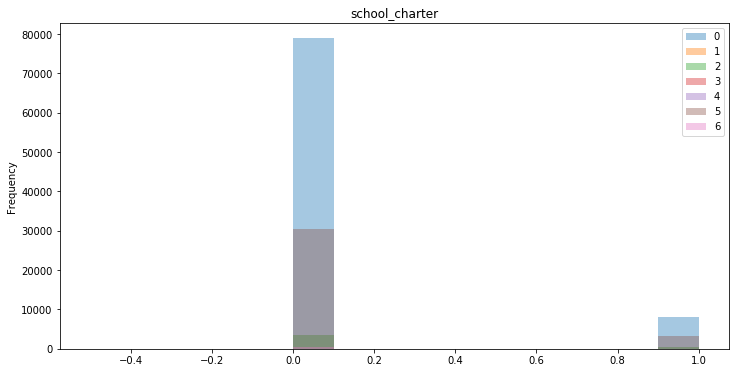

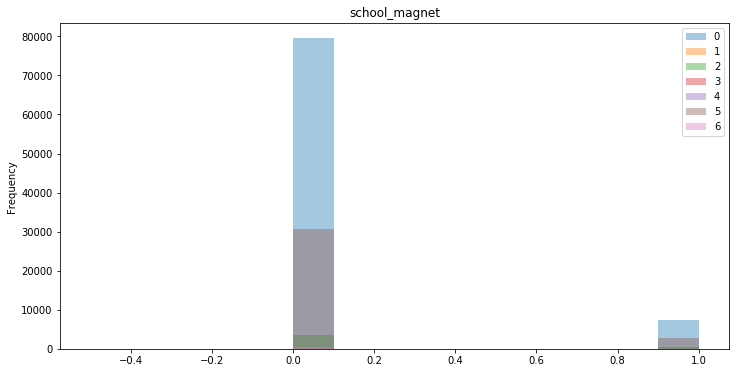

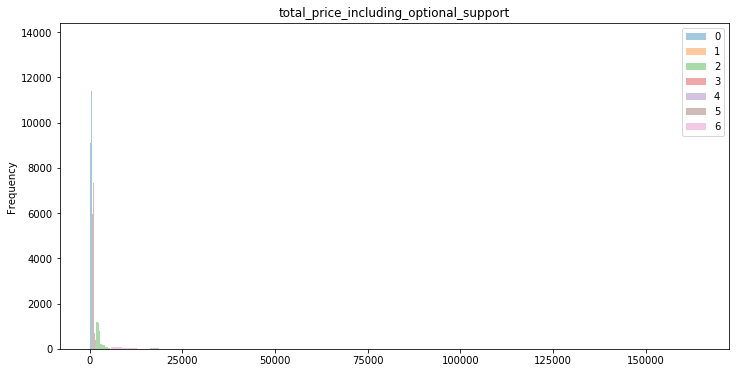

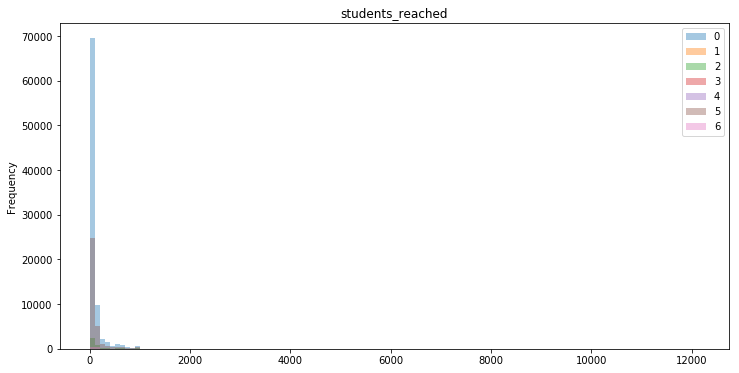

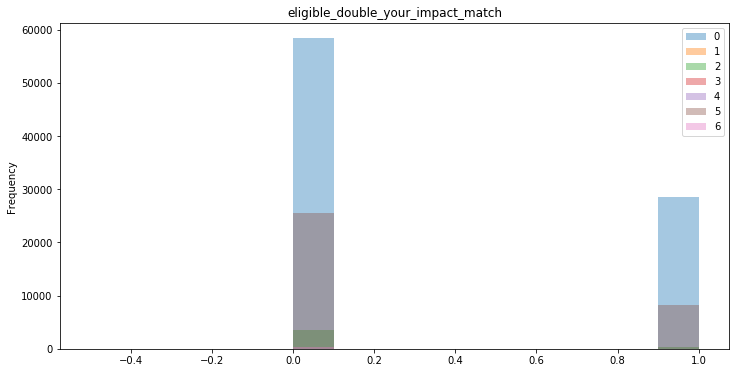

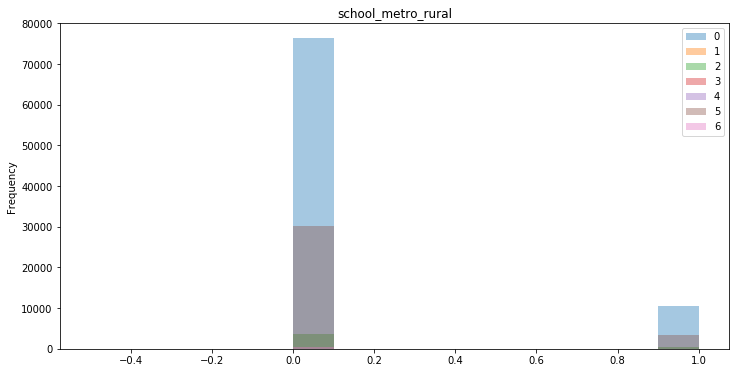

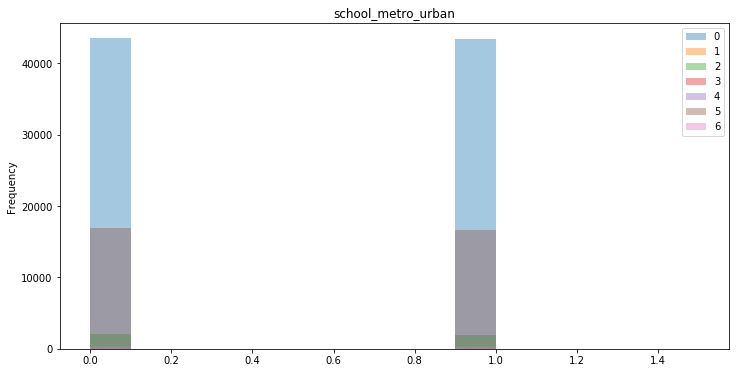

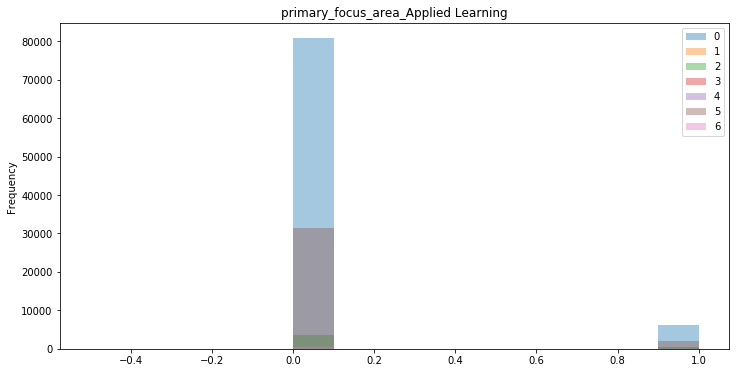

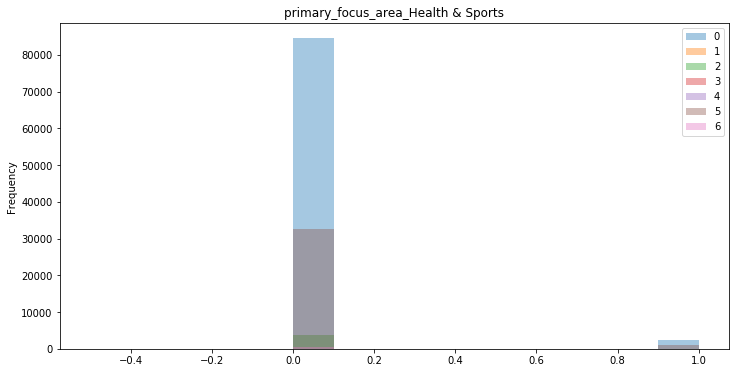

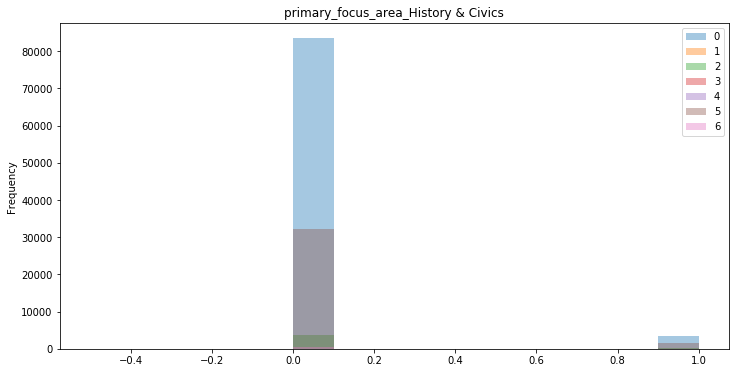

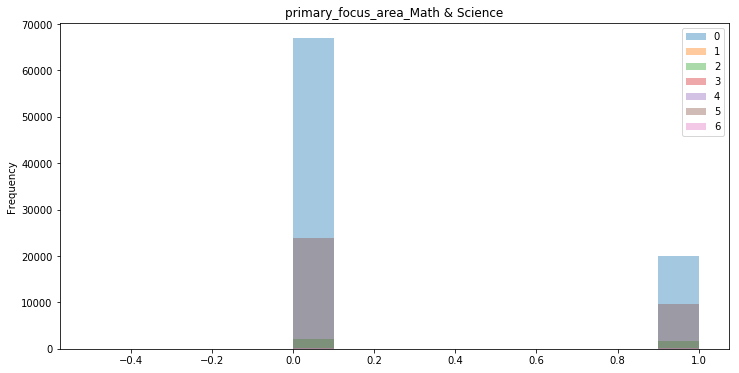

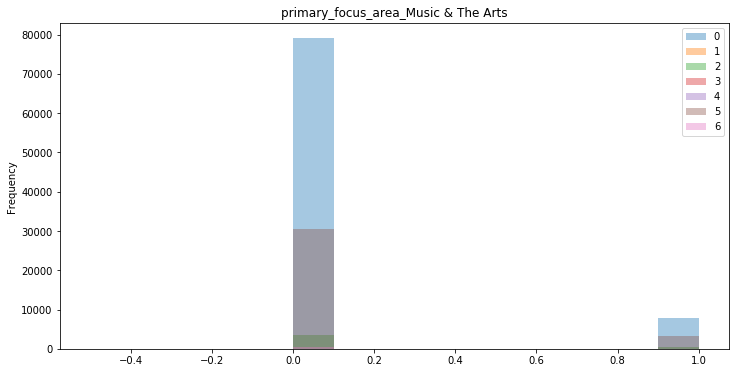

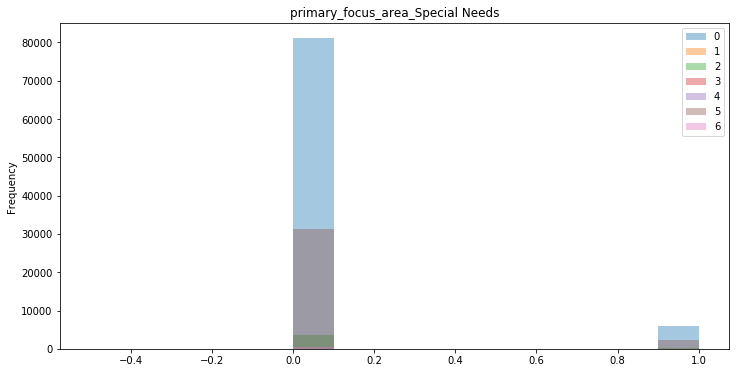

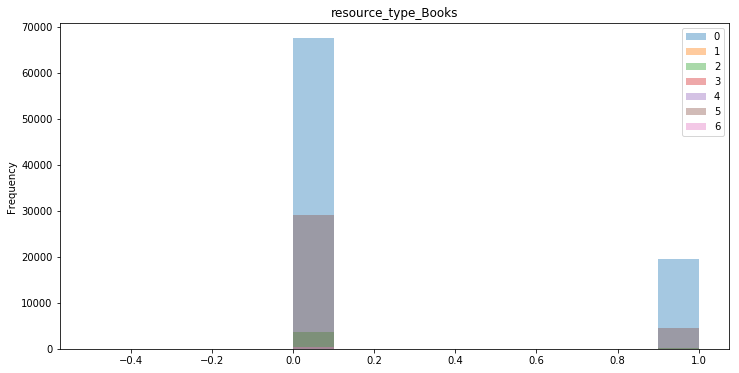

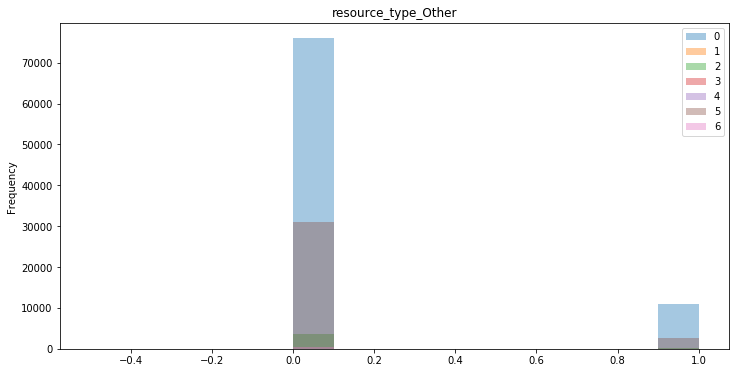

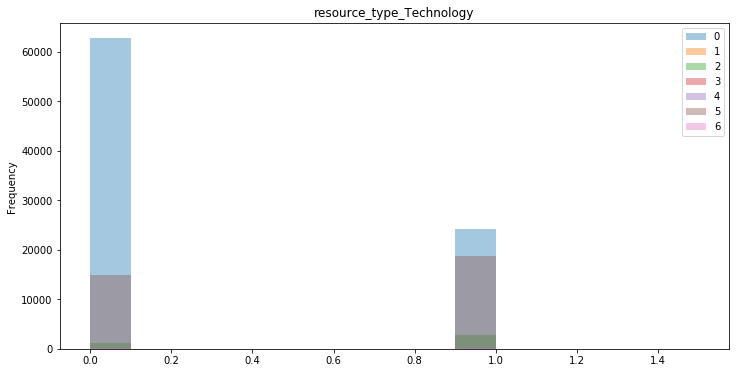

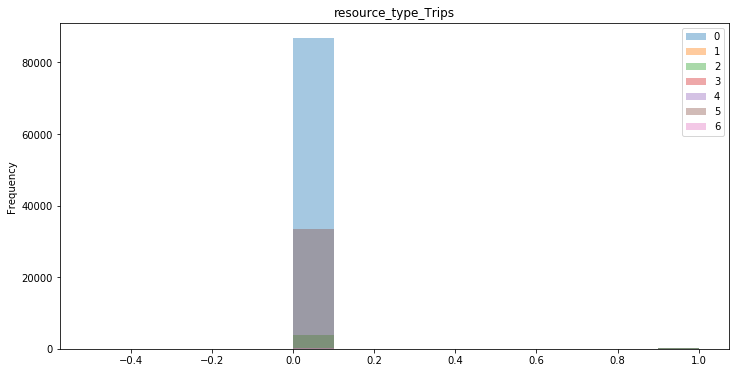

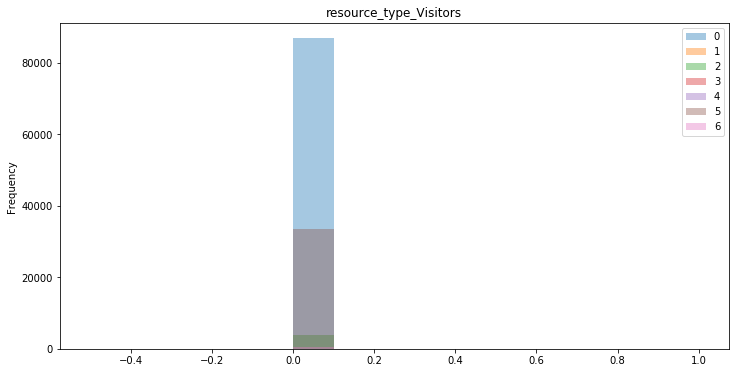

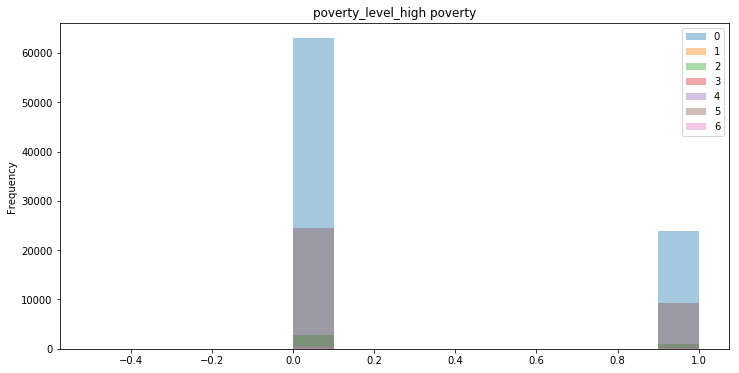

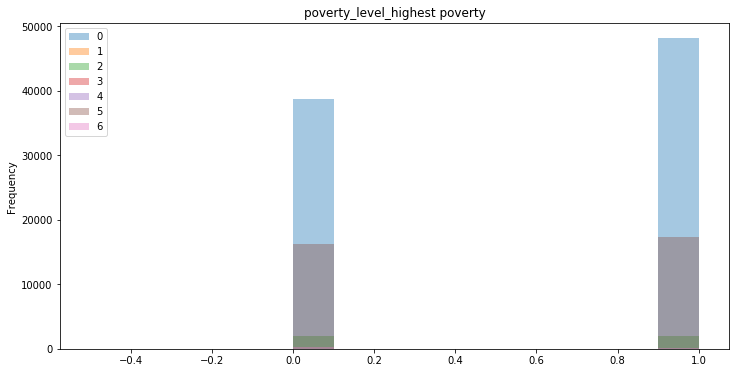

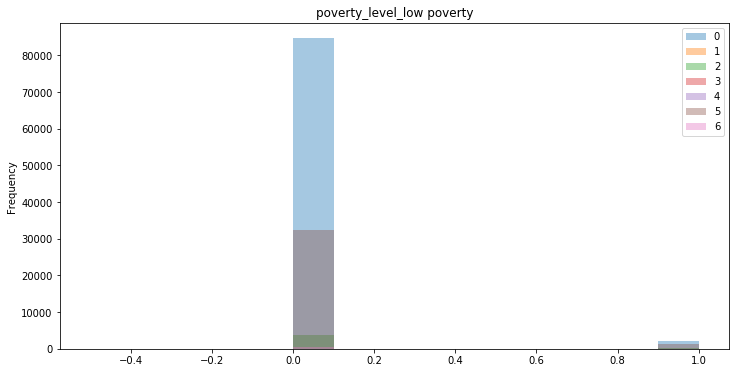

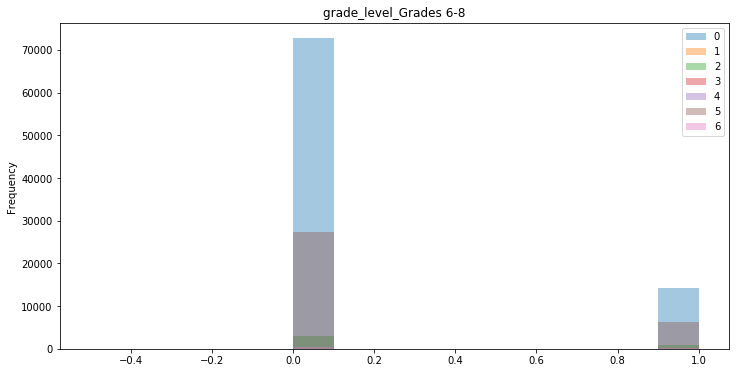

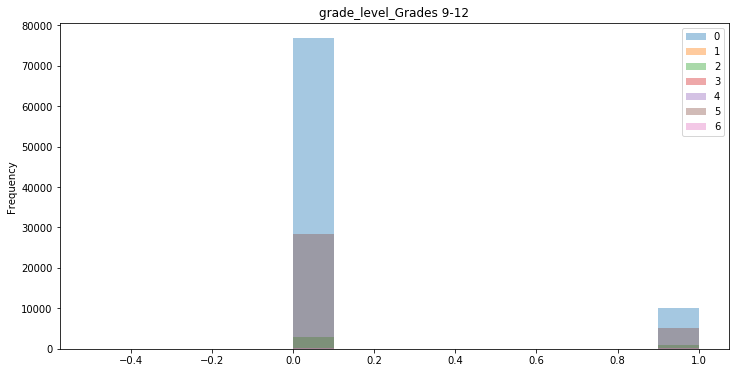

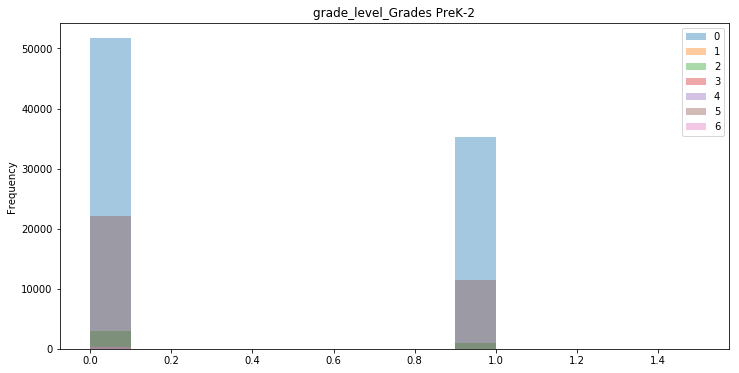

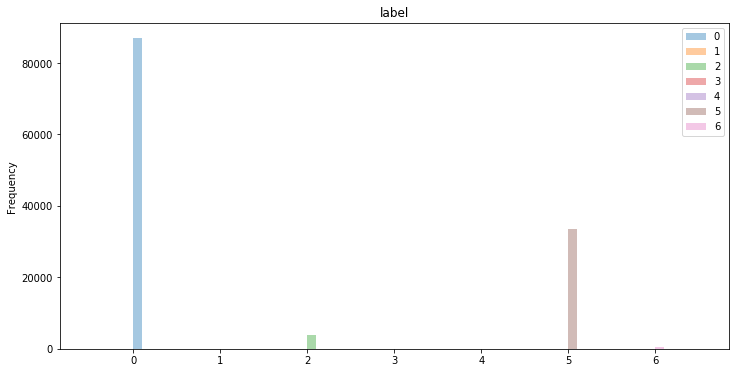

In [253]:
hwc.histogram_by_group(data_cluster,'label')

Describing each of the clusters produced

In [267]:
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
for each in data_cluster.label.unique():
    desc = data_cluster[data_cluster['label'] == each]
    description = desc.describe()
    print("Current cluster is", each)
    print(description)

Current cluster is 5
       school_charter  school_magnet  total_price_including_optional_support  students_reached  \
count       33641.000      33641.000                               33641.000         33641.000   
mean            0.096          0.085                                 923.324           107.714   
std             0.294          0.279                                 198.026           169.225   
min             0.000          0.000                                 631.010             1.000   
25%             0.000          0.000                                 771.860            24.000   
50%             0.000          0.000                                 898.780            36.000   
75%             0.000          0.000                                1007.710           119.000   
max             1.000          1.000                                1755.590           999.000   

       eligible_double_your_impact_match  school_metro_rural  school_metro_urban  \
count       

Current cluster is 3
       school_charter  school_magnet  total_price_including_optional_support  students_reached  \
count             1.0            1.0                                    1.00               1.0   
mean              0.0            0.0                               164382.84             650.0   
std               NaN            NaN                                     NaN               NaN   
min               0.0            0.0                               164382.84             650.0   
25%               0.0            0.0                               164382.84             650.0   
50%               0.0            0.0                               164382.84             650.0   
75%               0.0            0.0                               164382.84             650.0   
max               0.0            0.0                               164382.84             650.0   

       eligible_double_your_impact_match  school_metro_rural  school_metro_urban  \
count       

We will use our merging functions to merge clusters that, based on a comparison of the descriptive statistics, have a similarity between each other. In particular, the clusters 1,2,3,4; and 5 and 6 resemble. Consequently, we will have 3 clusters. 

In [314]:
data_cluster = hwc.merge_with_k(data_cluster,[1,2,3,4],1)
data_cluster = hwc.merge_with_k(data_cluster,[5,6],5)

We elaborate the new decriptive statistics in this new cluster

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through

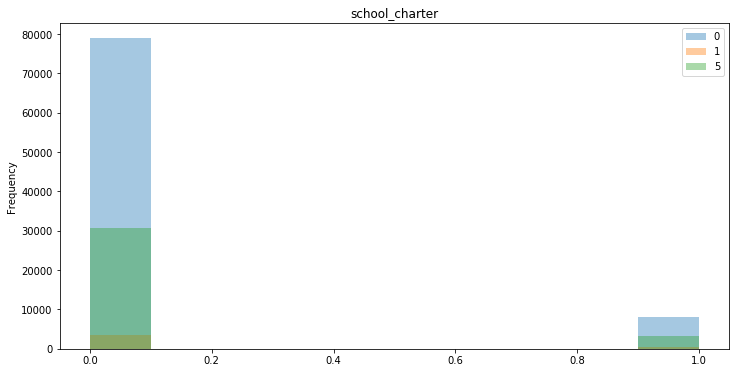

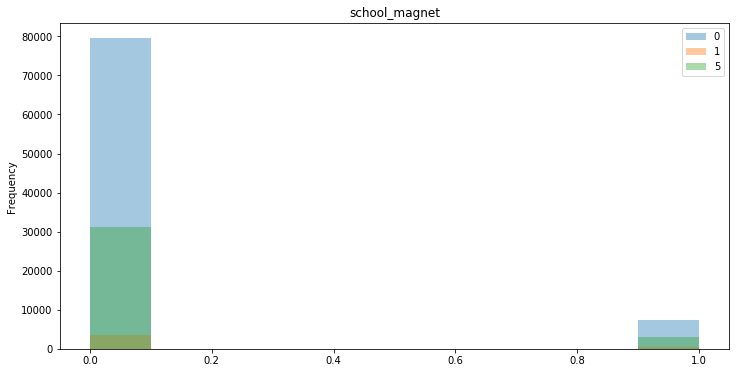

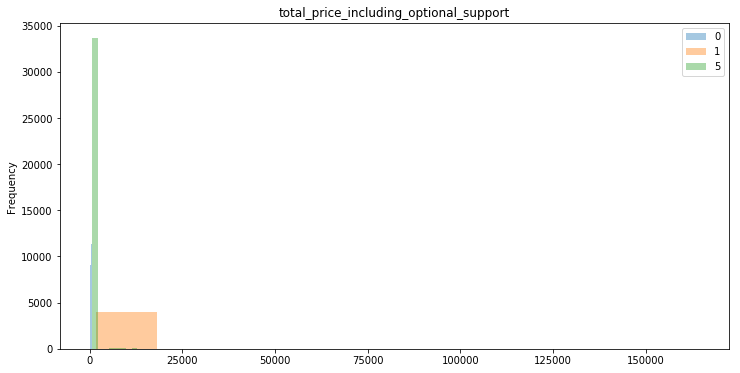

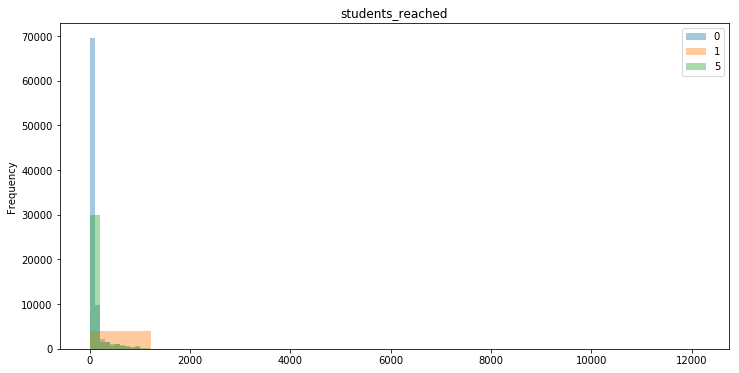

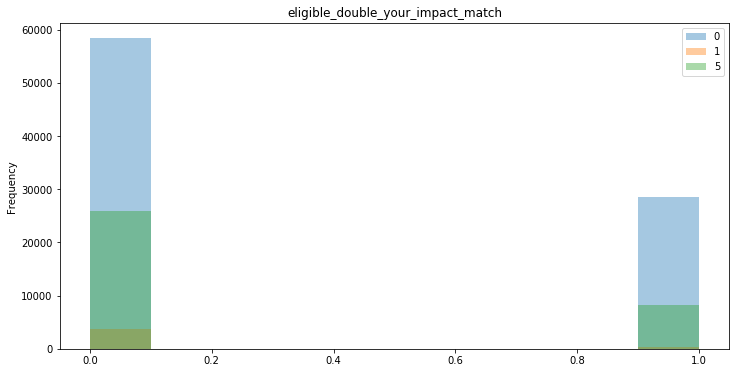

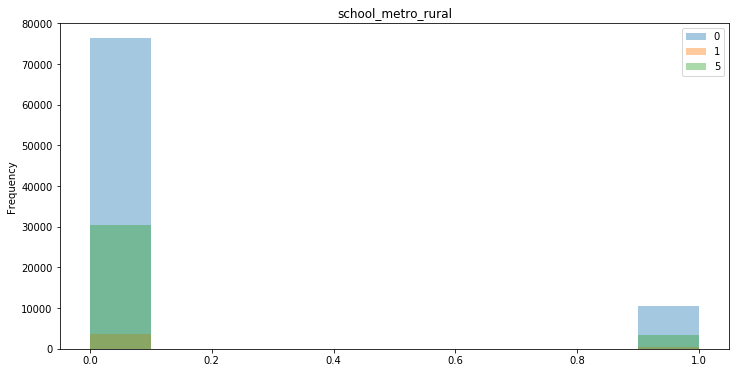

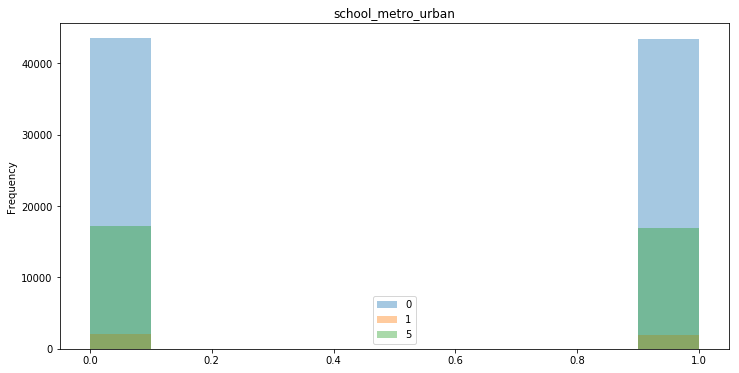

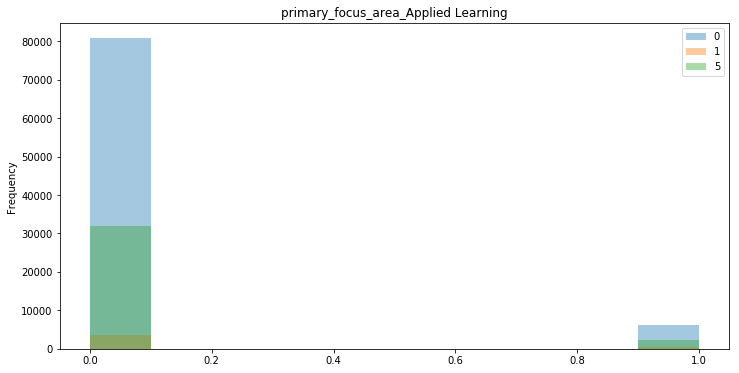

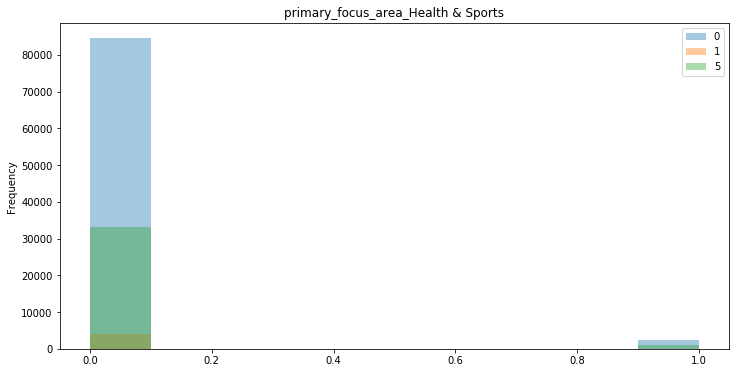

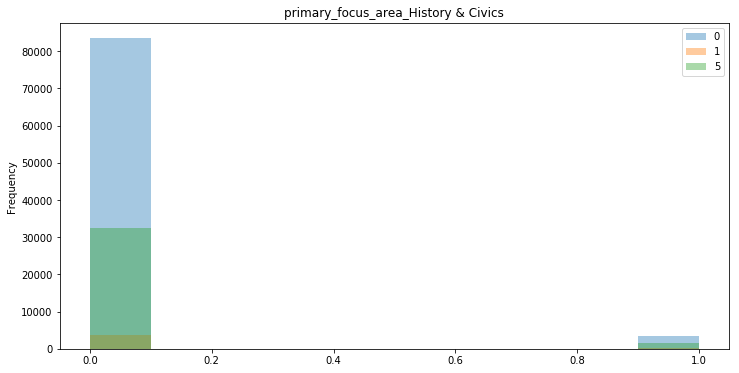

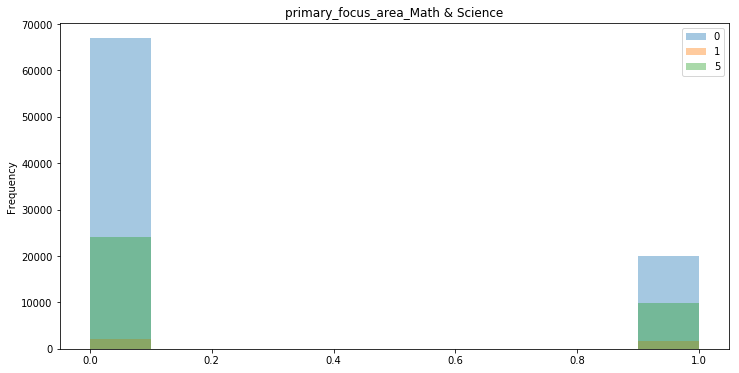

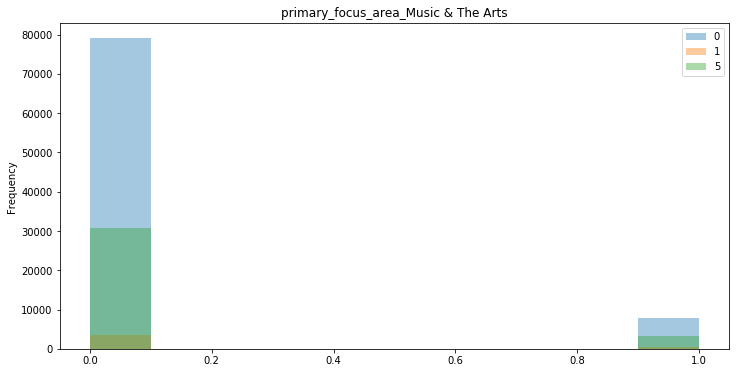

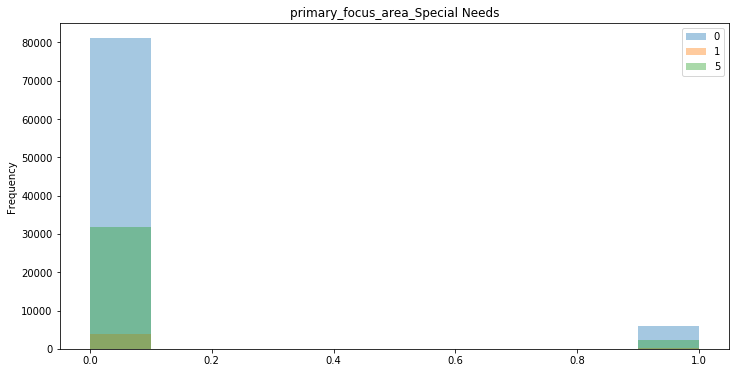

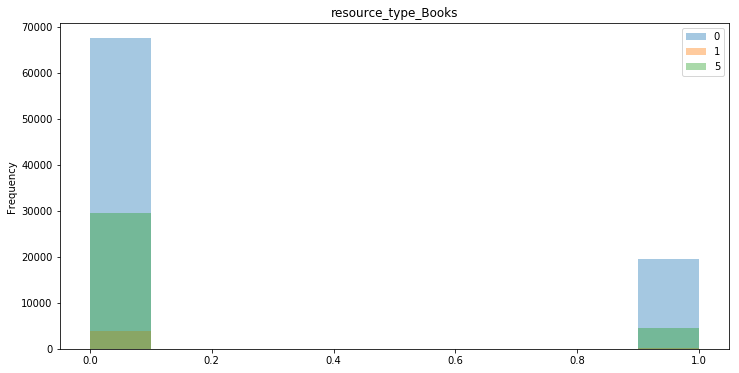

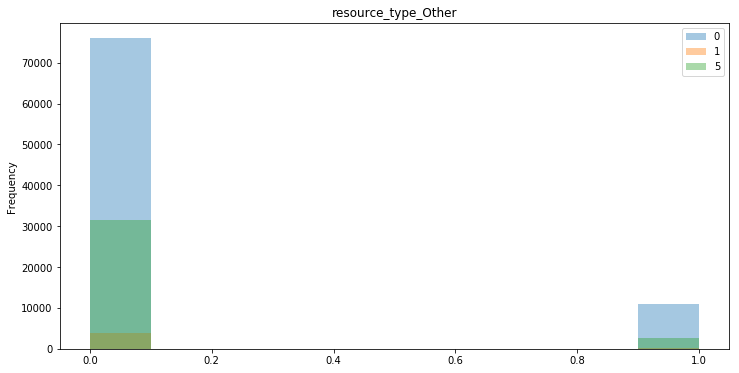

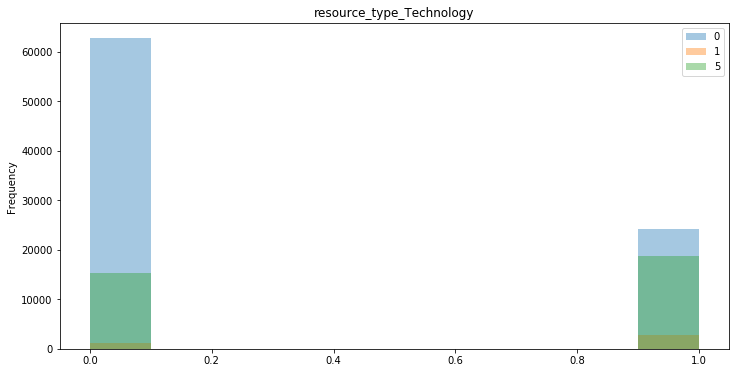

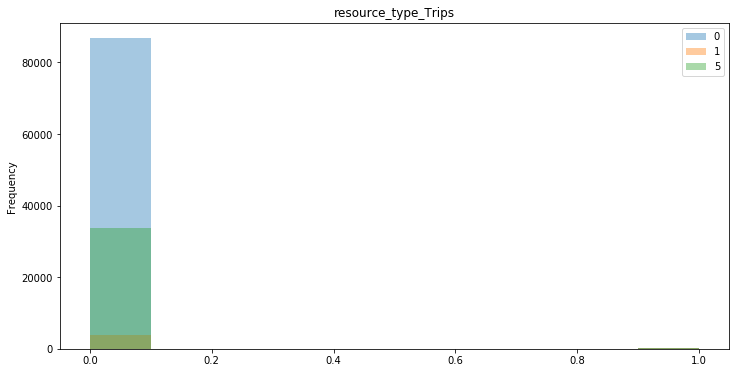

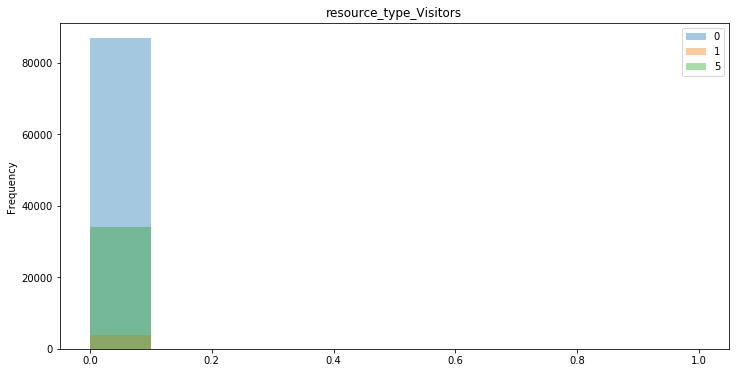

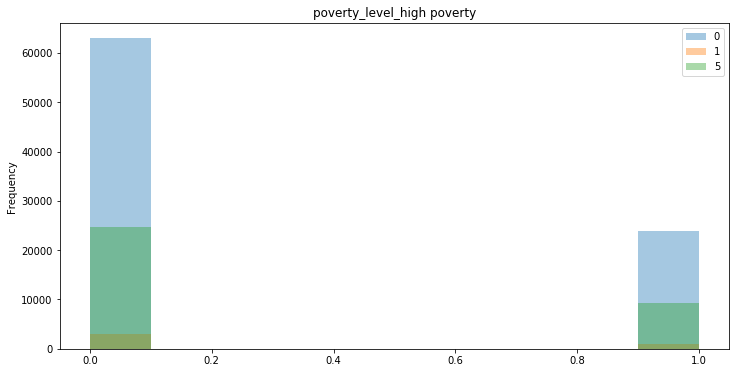

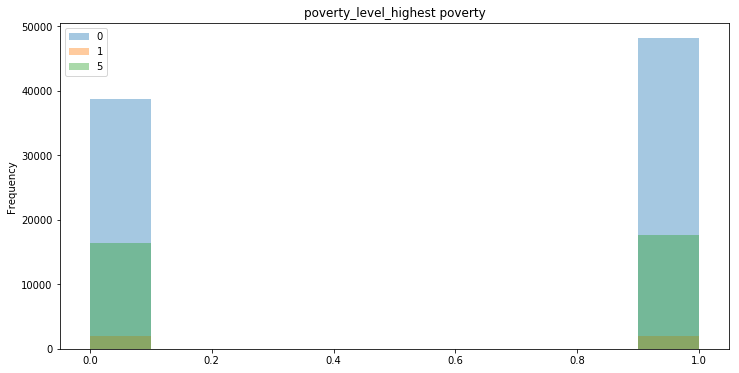

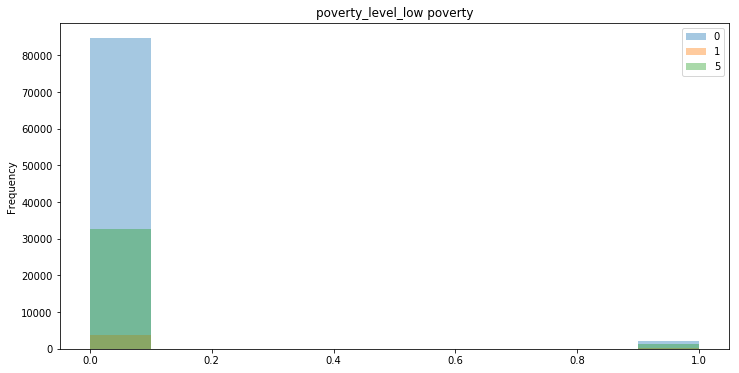

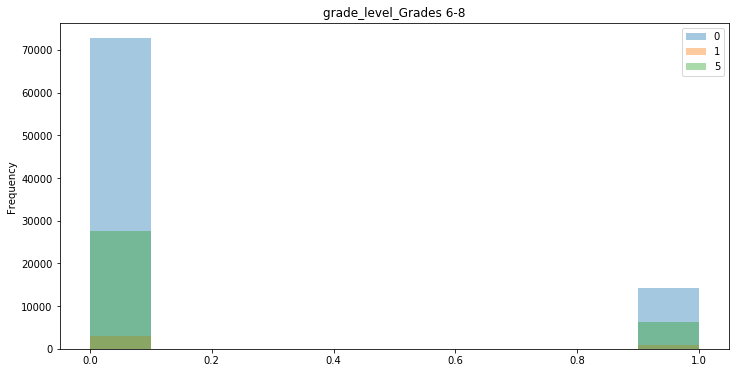

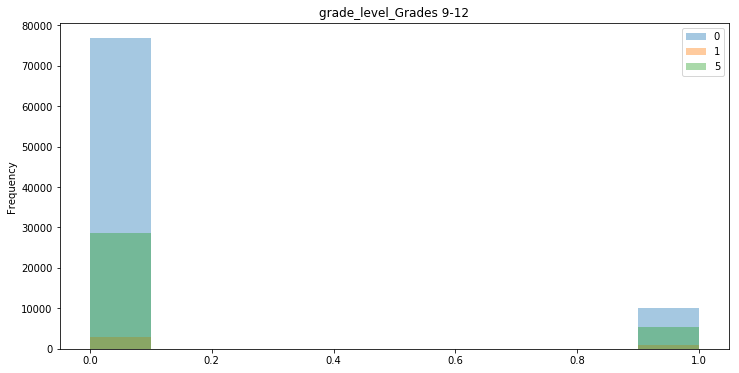

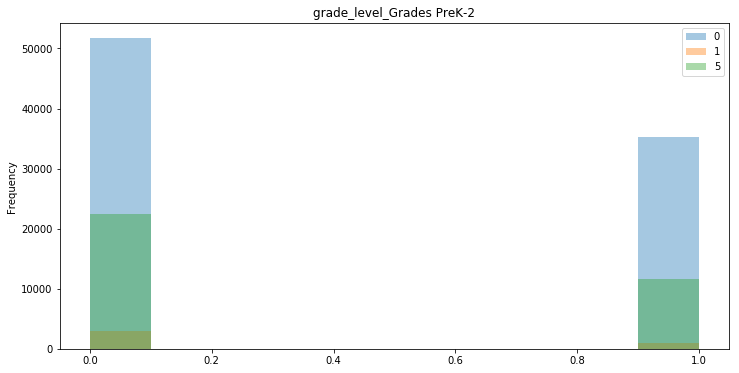

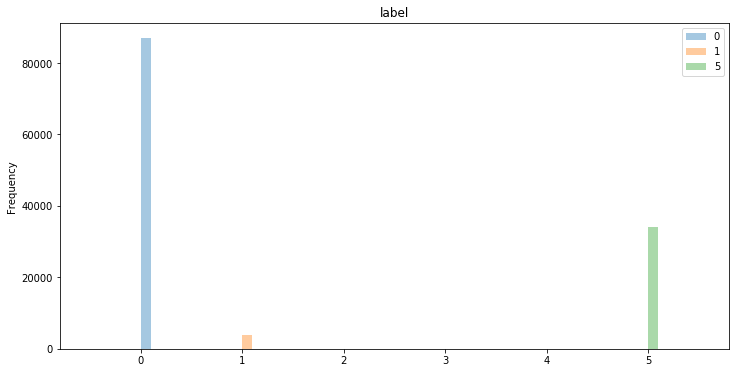

In [273]:
hwc.histogram_by_group(data_cluster,'label')

In [315]:
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
for each in data_cluster.label.unique():
    desc = data_cluster[data_cluster['label'] == each]
    description = desc.describe()
    print("Current cluster is", each)
    print(description)



Current cluster is 1
       school_charter  school_magnet  total_price_including_optional_support  students_reached  \
count       37623.000      37623.000                               37623.000         37623.000   
mean            0.095          0.086                                1140.247           113.508   
std             0.293          0.280                                1455.797           195.026   
min             0.000          0.000                                 631.010             1.000   
25%             0.000          0.000                                 787.210            24.000   
50%             0.000          0.000                                 929.530            40.000   
75%             0.000          0.000                                1069.590           120.000   
max             1.000          1.000                              100800.010         12143.000   

       eligible_double_your_impact_match  school_metro_rural  school_metro_urban  \
count       

We can see a clear difference between the clusters 

In [317]:
mean_groups = data_cluster.groupby(['label']).mean()
mean_groups

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,school_metro_rural,school_metro_urban,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2
label,,,,,,,,,,,,,,,,,,,,,,,,
0,0.092,0.085,404.953,87.167,0.328,0.122,0.499,0.071,0.028,0.040,0.230,0.091,0.067,0.224,0.126,0.279,0.002,5.865e-04,0.276,0.554,0.026,0.163,0.117,0.405
1,0.095,0.086,1140.247,113.508,0.227,0.100,0.496,0.066,0.029,0.044,0.306,0.095,0.066,0.126,0.073,0.571,0.012,2.339e-03,0.274,0.515,0.041,0.191,0.164,0.331
5,0.115,0.125,9082.711,183.622,0.040,0.115,0.486,0.130,0.023,0.088,0.481,0.100,0.030,0.048,0.095,0.459,0.198,1.003e-02,0.248,0.464,0.045,0.221,0.496,0.110


In [322]:
mean_ = mean_groups[['school_magnet', 'total_price_including_optional_support',
            'students_reached', 'eligible_double_your_impact_match',
            'primary_focus_area_Math & Science', 'resource_type_Books',
            'resource_type_Trips', 'poverty_level_highest poverty', 'grade_level_Grades 9-12',
            'grade_level_Grades PreK-2']]
mean_.transpose()

label,0,1,5
school_magnet,0.085,0.086,0.125
total_price_including_optional_support,404.953,1140.247,9082.711
students_reached,87.167,113.508,183.622
eligible_double_your_impact_match,0.328,0.227,0.040
primary_focus_area_Math & Science,0.230,0.306,0.481
resource_type_Books,0.224,0.126,0.048
resource_type_Trips,0.002,0.012,0.198
poverty_level_highest poverty,0.554,0.515,0.464
grade_level_Grades 9-12,0.117,0.164,0.496
grade_level_Grades PreK-2,0.405,0.331,0.110


We now replicate the analysis made for HW5 for the best model that was found here, and we will perform a cluster analysis for the top5% projects.

In [286]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

data_for_model = data.copy()
data_for_model.drop(columns=['school_metro_suburban','primary_focus_area_Literacy & Language',
                          'resource_type_Supplies','poverty_level_moderate poverty',
                          'grade_level_Grades 3-5'],inplace = True, axis = 1)

temp_lst = ep.temp_val('2012-01-01','2013-12-31',6,6,60)
X_train, X_test, y_train, y_test = ep.temp_spl(data_for_model,'date_posted',temp_lst[2],'label')       
X_train_ = np.array(X_train)
X_test_ = np.array(X_test)

clf = GradientBoostingClassifier(learning_rate=0.1, subsample=0.5, max_depth=5, n_estimators=100)
y_pred_probs = clf.fit(X_train_, y_train).predict_proba(X_test_)[:,1]
#y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs,y_test), reverse=True))


In [305]:
X_test['y_pred_prob'] = y_pred_probs
X_test.sort_values(by='y_pred_prob', ascending=False, inplace = True)
risk5pct = X_test.head(int(len(X_test)*(5/100)))


In [306]:
risk5pct.drop(columns=['y_pred','y_pred_prob'],inplace = True, axis = 1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [307]:
hwc.k_means(risk5pct,3,2000)

/Users/csolisu/30254/Machine_Learning/hw4/hw4_cluster.py:248: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['label'] = label


In [309]:
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
for each in risk5pct.label.unique():
    desc = risk5pct[risk5pct['label'] == each]
    description = desc.describe()
    print("Current cluster is", each)
    print(description)

Current cluster is 2
       school_charter  school_magnet  total_price_including_optional_support  students_reached  \
count        2058.000       2058.000                                2058.000          2058.000   
mean            0.094          0.080                                 566.299            96.781   
std             0.292          0.271                                 283.606           156.636   
min             0.000          0.000                                 154.730             1.000   
25%             0.000          0.000                                 346.882            23.000   
50%             0.000          0.000                                 511.165            32.000   
75%             0.000          0.000                                 766.070           100.000   
max             1.000          1.000                                1542.690           999.000   

       eligible_double_your_impact_match  school_metro_rural  school_metro_urban  \
count       

In [325]:
mean_groups_at_risk = risk5pct.groupby(['label']).mean()

mean_groups_at_risk

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,school_metro_rural,school_metro_urban,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2
label,,,,,,,,,,,,,,,,,,,,,,,,
0,0.109,0.051,2531.793,113.029,0.094,0.072,0.486,0.08,0.029,0.022,0.471,0.094,0.022,0.065,0.036,0.739,7.246e-03,0.000e+00,0.290,0.486,0.058,0.275,0.188,0.333
1,0.167,0.167,15655.778,207.167,0.000,0.333,0.500,0.00,0.000,0.000,0.667,0.167,0.000,0.000,0.167,0.667,0.000e+00,0.000e+00,0.167,0.167,0.000,0.333,0.500,0.000
2,0.094,0.080,566.299,96.781,0.307,0.117,0.468,0.06,0.031,0.038,0.250,0.086,0.069,0.196,0.117,0.379,4.859e-04,4.859e-04,0.276,0.542,0.032,0.172,0.125,0.378


In [327]:
mean_ = mean_groups_at_risk[['school_magnet', 'total_price_including_optional_support',
            'students_reached', 'eligible_double_your_impact_match','school_metro_rural',
            'primary_focus_area_Math & Science', 'resource_type_Books',
            'resource_type_Technology', 'poverty_level_highest poverty', 'grade_level_Grades 9-12',
            'grade_level_Grades PreK-2']]
mean_.transpose()

label,0,1,2
school_magnet,0.051,0.167,0.080
total_price_including_optional_support,2531.793,15655.778,566.299
students_reached,113.029,207.167,96.781
eligible_double_your_impact_match,0.094,0.000,0.307
school_metro_rural,0.072,0.333,0.117
primary_focus_area_Math & Science,0.471,0.667,0.250
resource_type_Books,0.065,0.000,0.196
resource_type_Technology,0.739,0.667,0.379
poverty_level_highest poverty,0.486,0.167,0.542
grade_level_Grades 9-12,0.188,0.500,0.125
